Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Change Directory to Working Directory

In [0]:
import os
os.chdir('/content/gdrive/My Drive/132A/Project')
!ls

 16QAM		     LLRs_4QAM_10.png   loss_16QAM_15.png   loss_BPSK_20.png
 4QAM		     LLRs_4QAM_15.png   loss_4QAM_10.png    Mixed
 BPSK		     LLRs_4QAM_20.png   loss_4QAM_15.png    Parameters.gsheet
'BPSK Trash Data'    LLRs_BPSK_10.png   loss_4QAM_20.png    Plots
 LLRs_16QAM_10.png   LLRs_BPSK_15.png   loss_BPSK_10.png
 LLRs_16QAM_15.png   LLRs_BPSK_20.png   loss_BPSK_15.png


Load and Preprocess Data

In [0]:
import numpy as np
import pandas as pd
import scipy.io as sio

def unison_shuffled_copies(a, b, c, d):
    assert (len(a) == len(b)) and (len(a) == len(c)) and (len(b) == len(c)) and (len(a)==len(d))
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]

sym_r = []
sym_i = []
LLR0 = []
LLR1 = []
for i in range(4):
  x = sio.loadmat('4QAM/Raw Data/10 dB/4QAM_sym_10_' + str(i+1) + '.mat')
  y0 = sio.loadmat('4QAM/Raw Data/10 dB/4QAM_LLR_b0_10_' + str(i+1) + '.mat')
  y1 = sio.loadmat('4QAM/Raw Data/10 dB/4QAM_LLR_b1_10_' + str(i+1) + '.mat')
  x_d = x['z_4QAM']
  LLR_b0 = y0['LLR_BPSK_b0']
  LLR_b1= y1['LLR_BPSK_b1']
  sym_r.append(np.asarray(x_d.real.ravel()))
  sym_i.append(np.asarray(x_d.imag.ravel()))
  LLR0.append(np.asarray(LLR_b0.ravel()))
  LLR1.append(np.asarray(LLR_b1.ravel()))
  sym_r[i] = sym_r[i].reshape(1,-1)
  sym_i[i] = sym_i[i].reshape(1,-1)
  LLR0[i] = LLR0[i].reshape(1,-1)
  LLR1[i] = LLR1[i].reshape(1,-1)
  sym_r[i][0], sym_i[i][0], LLR0[i][0], LLR1[i][0] = unison_shuffled_copies(sym_r[i][0], sym_i[i][0], LLR0[i][0], LLR1[i][0])
  


**Neural Network Definition**

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization, Activation
from keras import optimizers
from keras.regularizers import l1

def llr_model():
    Nsym = 10000
    input1 = Input(shape=(Nsym, ))
    input2 = Input(shape=(Nsym, ))
    merged = Concatenate(axis=1)([input1, input2])
    
    dense1 = Dense(4096, kernel_initializer='truncated_normal', activation = 'relu')(merged)
    dropout1 = Dropout(0.1)(dense1)

    dense2 = Dense(1024, kernel_initializer='truncated_normal', activation = 'relu')(dense1)
    dropout2 = Dropout(0.2)(dense2)

    dense3 = Dense(256, kernel_initializer='truncated_normal', activation = 'relu')(dropout2)
    dropout3 = Dropout(0.4)(dense3)

    dense4 = Dense(1024, kernel_initializer='truncated_normal', activation = 'relu')(dropout2)
    dropout4 = Dropout(0.8)(dense4)

    output0 = Dense(10000, kernel_initializer='truncated_normal', activation = 'linear')(dropout4)
    output1 = Dense(10000, kernel_initializer='truncated_normal', activation = 'linear')(dropout4)
    model = Model(inputs=[input1, input2], output = [output0, output1])
  
    Adam=optimizers.Adam(lr=1.0, beta_1=0.9, beta_2=0.999, decay=0.99, amsgrad=False)
    model.compile(loss="mean_squared_logarithmic_error", optimizer = 'Adam', metrics = ["mean_squared_error"], target_tensors = None)
    
    return model


Using TensorFlow backend.


**Train and Evaluate Neural Network Model**

In [0]:
import keras
import matplotlib.pyplot as plt

batchsize = 2**7  # training batch size
snrdb = 5.0
nb_epochs = 50    # number of epochs to train on
model = llr_model()

print (model.summary())
history = model.fit([sym_r[0], sym_i[0]], [LLR0[0], LLR1[0]], batch_size=batchsize, epochs = 500, validation_data = ([sym_r[1], sym_i[1]], [LLR0[1], LLR1[1]]), shuffle=True)

# Show performance
score = model.evaluate([sym_r[2], sym_i[2]], [LLR0[2], LLR1[2]], steps = batchsize)
print(score)

fig = plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.legend()
fig.savefig("4QAM/loss_4QAM_10.png")
plt.close(fig)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 20000)        0           input_1[0][0]                    
                                                                 input_2[0][0]                    
______________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1 samples, validate on 1 samples
Epoch 1/500





1/1 [==============================] - 10s 10s/step - loss: 12.1208 - dense_5_loss: 6.1405 - dense_6_loss: 5.9803 - dense_5_mean_squared_error: 2596.2344 - dense_6_mean_squared_error: 2593.6021 - val_loss: 10.8487 - val_dense_5_loss: 5.4842 - val_dense_6_loss: 5.3645 - val_dense_5_mean_squared_error: 1803.7532 - val_dense_6_mean_squared_error: 1810.3748
Epoch 2/500
1/1 [==============================] - 0s 133ms/step - loss: 15.6526 - dense_5_loss: 7.8646 - dense_6_loss: 7.7880 - dense_5_mean_squared_error: 11315.5352 - dense_6_mean_squared_error: 11285.9805 - val_loss: 10.8428 - val_dense_5_loss: 5.4625 - val_dense_6_loss: 5.3803 - val_dense_5_mean_squared_error: 1798.3368 - val_dense_6_mean_squared_error: 1805.0264
Epoch 3/500
1/1 [==============================] - 0s 130ms/step - loss: 16.9900 - dense_5_loss: 8.4103 - dense_6_los

**Plot True and NN LLRs**

1/1 [==============================] - 0s 50ms/step
[ 37.106987 -40.4633    32.48432  ...  35.061653 -31.13302  -35.50313 ]
[-21.122713  38.80484   51.570255 ... -27.609215 -27.548279 -47.479656]


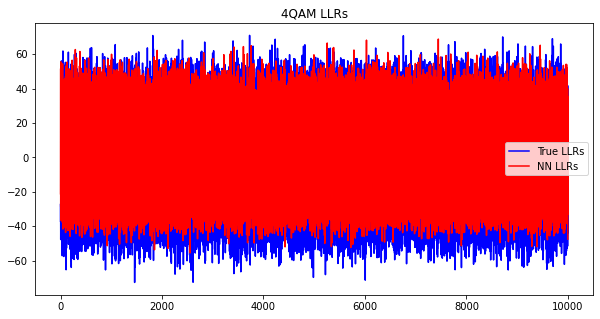

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
pred_llrs0, pred_llrs1 = model.predict([sym_r[3], sym_i[3]], verbose = 1, batch_size = None)
print (pred_llrs0[0])
print (pred_llrs1[0])
plt.plot(LLR1[3][0],'b', label = 'True LLRs')
plt.plot(pred_llrs1[0],'r', label = 'NN LLRs')
plt.title('4QAM LLRs')
plt.legend()
plt.show()
fig.savefig("4QAM/LLRs_4QAM_10.png")

**Plot LLRs of Bit #0**

[ 37.106987 -40.4633    32.48432  ...  35.061653 -31.13302  -35.50313 ]
[-33.17464018  48.43767379 -44.98088899 ...  43.56569332 -44.93653391
 -38.0573988 ]


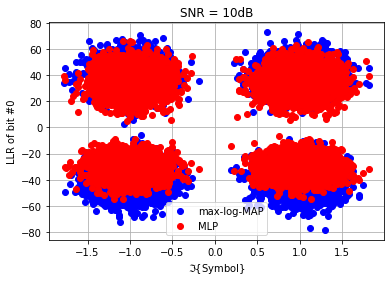

In [0]:
print(pred_llrs0[0])
print(LLR0[3][0])
fig2 = plt.figure()
plt.grid(True)
plt.scatter(sym_i[3], LLR0[3], c='b', label = 'max-log-MAP',zorder=2)
plt.scatter(sym_i[3], pred_llrs0[0], c='r', label = 'MLP',zorder=3)
plt.ylabel('LLR of bit #0')
plt.xlabel(r'$\Im$' + '{Symbol}')
plt.title('SNR = 10dB')
plt.legend()
fig2.savefig("Plots/4QAM_LLR_b0_10.png")
plt.show()

**Plot LLRs of Bit #1**

[ 37.106987 -40.4633    32.48432  ...  35.061653 -31.13302  -35.50313 ]
[-33.17464018  48.43767379 -44.98088899 ...  43.56569332 -44.93653391
 -38.0573988 ]


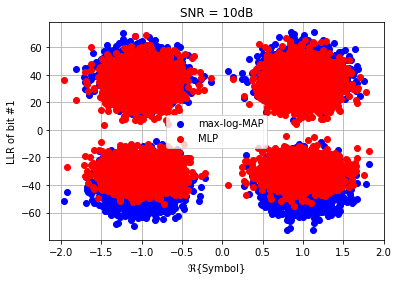

In [0]:
print(pred_llrs0[0])
print(LLR0[3][0])
fig3 = plt.figure()
plt.grid(True)
plt.scatter(sym_r[3], LLR1[3], c='b', label = 'max-log-MAP',zorder=2)
plt.scatter(sym_r[3], pred_llrs1[0], c='r', label = 'MLP',zorder=3)
plt.ylabel('LLR of bit #1')
plt.xlabel(r'$\Re$' + '{Symbol}')
plt.title('SNR = 10dB')
plt.legend()
fig3.savefig("Plots/4QAM_LLR_b1_10.png")
plt.show()